## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128] , l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation='relu', name='hidden_layer'+str(i+1), kernel_regularizer=l1(l1_ratio))(input_layer)
            x = keras.layers.BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, activation='relu', name='hidden_layer'+str(i+1), kernel_regularizer=l1(l1_ratio))(x)
            x = keras.layers.BatchNormalization()(x)
            
    out = keras.layers.Dense(units=output_units, activation='softmax', name='output', kernel_regularizer=l1(l1_ratio))(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = [1e-3, 5e-3, 5e-4]
EPOCHS = 50
BATCH_SIZE = 32
OPTIMIZER = [keras.optimizers.RMSprop, keras.optimizers.Adagrad, keras.optimizers.Adam]

In [7]:
results = {}
for lr, opti in itertools.product(LEARNING_RATE, OPTIMIZER):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f, Optimizer = %s" % (lr, str(opti)))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    
    optimizer = opti(lr=lr)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-lr-%s-optimizer-%s" % (str(lr), str(opti))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with LR = 0.001000, Optimizer = <class 'keras.optimizers.RMSprop'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
________________________________________________________________

50000/50000 [==============================] - 14s 271us/step - loss: 1.7871 - acc: 0.4902 - val_loss: 2.0139 - val_acc: 0.4276
Epoch 49/50
50000/50000 [==============================] - 14s 273us/step - loss: 1.7888 - acc: 0.4930 - val_loss: 2.0914 - val_acc: 0.3958
Epoch 50/50
50000/50000 [==============================] - 14s 271us/step - loss: 1.7950 - acc: 0.4916 - val_loss: 1.9109 - val_acc: 0.4458
Experiment with LR = 0.001000, Optimizer = <class 'keras.optimizers.Adagrad'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
____________________________________________________

Epoch 46/50
50000/50000 [==============================] - 13s 257us/step - loss: 3.0714 - acc: 0.6637 - val_loss: 3.4869 - val_acc: 0.5112
Epoch 47/50
50000/50000 [==============================] - 13s 256us/step - loss: 3.0573 - acc: 0.6673 - val_loss: 3.4809 - val_acc: 0.5119
Epoch 48/50
50000/50000 [==============================] - 13s 257us/step - loss: 3.0479 - acc: 0.6697 - val_loss: 3.4749 - val_acc: 0.5115
Epoch 49/50
50000/50000 [==============================] - 13s 256us/step - loss: 3.0319 - acc: 0.6742 - val_loss: 3.4883 - val_acc: 0.5085
Epoch 50/50
50000/50000 [==============================] - 13s 256us/step - loss: 3.0219 - acc: 0.6745 - val_loss: 3.4593 - val_acc: 0.5152
Experiment with LR = 0.001000, Optimizer = <class 'keras.optimizers.Adam'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
___________________________

Epoch 44/50
50000/50000 [==============================] - 16s 325us/step - loss: 1.6472 - acc: 0.5034 - val_loss: 1.7716 - val_acc: 0.4595
Epoch 45/50
50000/50000 [==============================] - 16s 325us/step - loss: 1.6526 - acc: 0.5030 - val_loss: 1.8341 - val_acc: 0.4428
Epoch 46/50
50000/50000 [==============================] - 16s 325us/step - loss: 1.6759 - acc: 0.4982 - val_loss: 1.9539 - val_acc: 0.4033
Epoch 47/50
50000/50000 [==============================] - 16s 324us/step - loss: 1.6735 - acc: 0.4960 - val_loss: 1.8725 - val_acc: 0.4212
Epoch 48/50
50000/50000 [==============================] - 16s 325us/step - loss: 1.6590 - acc: 0.5028 - val_loss: 1.8501 - val_acc: 0.4282
Epoch 49/50
50000/50000 [==============================] - 16s 324us/step - loss: 1.6608 - acc: 0.4990 - val_loss: 1.9789 - val_acc: 0.4046
Epoch 50/50
50000/50000 [==============================] - 16s 324us/step - loss: 1.6646 - acc: 0.4980 - val_loss: 1.8288 - val_acc: 0.4398
Experiment with LR =

50000/50000 [==============================] - 14s 288us/step - loss: 2.3608 - acc: 0.3932 - val_loss: 2.5481 - val_acc: 0.3254
Epoch 42/50
50000/50000 [==============================] - 14s 288us/step - loss: 2.3604 - acc: 0.3918 - val_loss: 2.4715 - val_acc: 0.3642
Epoch 43/50
50000/50000 [==============================] - 14s 288us/step - loss: 2.3570 - acc: 0.3956 - val_loss: 2.4538 - val_acc: 0.3594
Epoch 44/50
50000/50000 [==============================] - 14s 288us/step - loss: 2.3483 - acc: 0.3985 - val_loss: 2.5058 - val_acc: 0.3564
Epoch 45/50
50000/50000 [==============================] - 14s 288us/step - loss: 2.3520 - acc: 0.3947 - val_loss: 2.9567 - val_acc: 0.2590
Epoch 46/50
50000/50000 [==============================] - 14s 289us/step - loss: 2.3534 - acc: 0.3980 - val_loss: 2.6633 - val_acc: 0.2967
Epoch 47/50
50000/50000 [==============================] - 14s 289us/step - loss: 2.3554 - acc: 0.3960 - val_loss: 2.3590 - val_acc: 0.3963
Epoch 48/50
50000/50000 [=======

Epoch 39/50
50000/50000 [==============================] - 14s 274us/step - loss: 1.6419 - acc: 0.5876 - val_loss: 1.9547 - val_acc: 0.4785
Epoch 40/50
50000/50000 [==============================] - 14s 274us/step - loss: 1.6428 - acc: 0.5834 - val_loss: 1.8983 - val_acc: 0.4969
Epoch 41/50
50000/50000 [==============================] - 14s 275us/step - loss: 1.6387 - acc: 0.5887 - val_loss: 1.9007 - val_acc: 0.4969
Epoch 42/50
50000/50000 [==============================] - 14s 276us/step - loss: 1.6235 - acc: 0.5924 - val_loss: 2.1549 - val_acc: 0.4277
Epoch 43/50
50000/50000 [==============================] - 14s 274us/step - loss: 1.6186 - acc: 0.5896 - val_loss: 2.2121 - val_acc: 0.4219
Epoch 44/50
50000/50000 [==============================] - 14s 275us/step - loss: 1.6126 - acc: 0.5915 - val_loss: 2.1522 - val_acc: 0.4386
Epoch 45/50
50000/50000 [==============================] - 14s 276us/step - loss: 1.6035 - acc: 0.5959 - val_loss: 2.0361 - val_acc: 0.4596
Epoch 46/50
50000/50

Epoch 37/50
50000/50000 [==============================] - 16s 326us/step - loss: 2.0556 - acc: 0.4178 - val_loss: 2.1602 - val_acc: 0.3832
Epoch 38/50
50000/50000 [==============================] - 16s 327us/step - loss: 2.0595 - acc: 0.4135 - val_loss: 2.1700 - val_acc: 0.3668
Epoch 39/50
50000/50000 [==============================] - 16s 325us/step - loss: 2.0348 - acc: 0.4157 - val_loss: 2.1793 - val_acc: 0.3916
Epoch 40/50
50000/50000 [==============================] - 16s 327us/step - loss: 2.0418 - acc: 0.4144 - val_loss: 2.1814 - val_acc: 0.3812
Epoch 41/50
50000/50000 [==============================] - 16s 327us/step - loss: 2.0328 - acc: 0.4176 - val_loss: 2.1839 - val_acc: 0.3862
Epoch 42/50
50000/50000 [==============================] - 16s 326us/step - loss: 2.0360 - acc: 0.4182 - val_loss: 2.1172 - val_acc: 0.3962
Epoch 43/50
50000/50000 [==============================] - 16s 327us/step - loss: 2.0424 - acc: 0.4153 - val_loss: 2.6063 - val_acc: 0.2308
Epoch 44/50
50000/50

50000/50000 [==============================] - 14s 289us/step - loss: 1.6172 - acc: 0.5262 - val_loss: 1.8995 - val_acc: 0.4436
Epoch 35/50
50000/50000 [==============================] - 14s 288us/step - loss: 1.6107 - acc: 0.5313 - val_loss: 1.9505 - val_acc: 0.4313
Epoch 36/50
50000/50000 [==============================] - 14s 288us/step - loss: 1.6105 - acc: 0.5303 - val_loss: 1.7875 - val_acc: 0.4761
Epoch 37/50
50000/50000 [==============================] - 14s 288us/step - loss: 1.6086 - acc: 0.5311 - val_loss: 1.8854 - val_acc: 0.4263
Epoch 38/50
50000/50000 [==============================] - 14s 288us/step - loss: 1.6051 - acc: 0.5292 - val_loss: 1.9509 - val_acc: 0.4181
Epoch 39/50
50000/50000 [==============================] - 14s 289us/step - loss: 1.6055 - acc: 0.5336 - val_loss: 1.8803 - val_acc: 0.4302
Epoch 40/50
50000/50000 [==============================] - 14s 288us/step - loss: 1.6091 - acc: 0.5343 - val_loss: 1.8923 - val_acc: 0.4421
Epoch 41/50
50000/50000 [=======

Epoch 32/50
50000/50000 [==============================] - 14s 278us/step - loss: 4.3778 - acc: 0.5647 - val_loss: 4.5483 - val_acc: 0.5037
Epoch 33/50
50000/50000 [==============================] - 14s 278us/step - loss: 4.3547 - acc: 0.5713 - val_loss: 4.5436 - val_acc: 0.4987
Epoch 34/50
50000/50000 [==============================] - 14s 278us/step - loss: 4.3377 - acc: 0.5726 - val_loss: 4.5278 - val_acc: 0.5010
Epoch 35/50
50000/50000 [==============================] - 14s 278us/step - loss: 4.3274 - acc: 0.5734 - val_loss: 4.5229 - val_acc: 0.5012
Epoch 36/50
50000/50000 [==============================] - 14s 278us/step - loss: 4.3133 - acc: 0.5765 - val_loss: 4.5112 - val_acc: 0.5034
Epoch 37/50
50000/50000 [==============================] - 14s 278us/step - loss: 4.2993 - acc: 0.5770 - val_loss: 4.5035 - val_acc: 0.5015
Epoch 38/50
50000/50000 [==============================] - 14s 279us/step - loss: 4.2863 - acc: 0.5782 - val_loss: 4.4958 - val_acc: 0.4991
Epoch 39/50
50000/50

Epoch 30/50
50000/50000 [==============================] - 16s 324us/step - loss: 1.5614 - acc: 0.5273 - val_loss: 1.6316 - val_acc: 0.4995
Epoch 31/50
50000/50000 [==============================] - 16s 324us/step - loss: 1.5564 - acc: 0.5259 - val_loss: 1.7967 - val_acc: 0.4427
Epoch 32/50
50000/50000 [==============================] - 16s 323us/step - loss: 1.5542 - acc: 0.5318 - val_loss: 1.9056 - val_acc: 0.4114
Epoch 33/50
50000/50000 [==============================] - 16s 325us/step - loss: 1.5505 - acc: 0.5298 - val_loss: 1.6505 - val_acc: 0.4945
Epoch 34/50
50000/50000 [==============================] - 16s 324us/step - loss: 1.5518 - acc: 0.5304 - val_loss: 1.7893 - val_acc: 0.4514
Epoch 35/50
50000/50000 [==============================] - 16s 325us/step - loss: 1.5462 - acc: 0.5333 - val_loss: 1.8917 - val_acc: 0.4295
Epoch 36/50
50000/50000 [==============================] - 16s 324us/step - loss: 1.5450 - acc: 0.5320 - val_loss: 1.7976 - val_acc: 0.4436
Epoch 37/50
50000/50

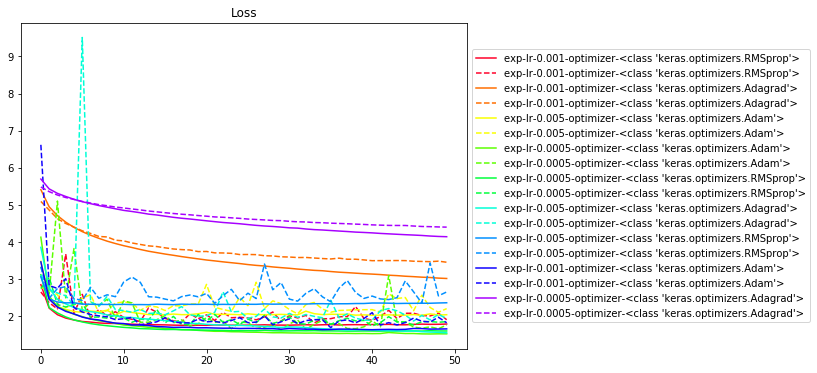

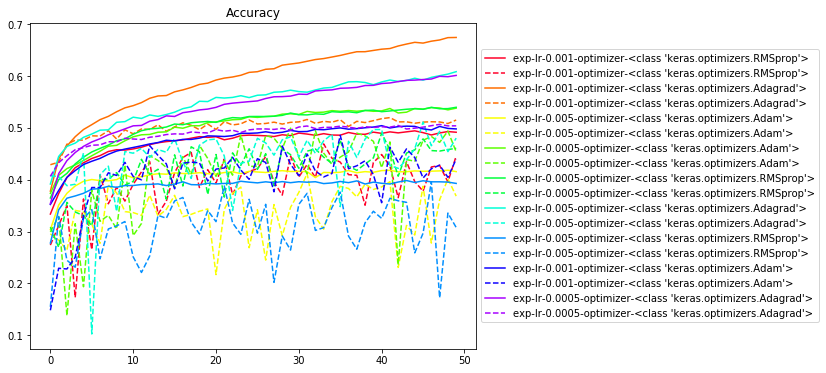

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline 
    
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()